In [200]:
# Import Libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

In [201]:
# Read in data
df = pd.read_csv("UsArrests.csv")
df.head()

,City,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6


In [203]:
# Drop 'City' column
df = df.drop("City", axis = 1)

In [204]:
# Check the variables for missing values
df.isna().sum()

Murder      0
Assault     0
UrbanPop    0
Rape        0
dtype: int64

In [205]:
# Get an overview of the data for each variable
df.describe()

,Murder,Assault,UrbanPop,Rape
count,50.00000,50.000000,50.000000,50.000000
mean,7.78800,170.760000,65.540000,21.232000
std,4.35551,83.337661,14.474763,9.366385
min,0.80000,45.000000,32.000000,7.300000
25%,4.07500,109.000000,54.500000,15.075000
50%,7.25000,159.000000,66.000000,20.100000
75%,11.25000,249.000000,77.750000,26.175000
max,17.40000,337.000000,91.000000,46.000000


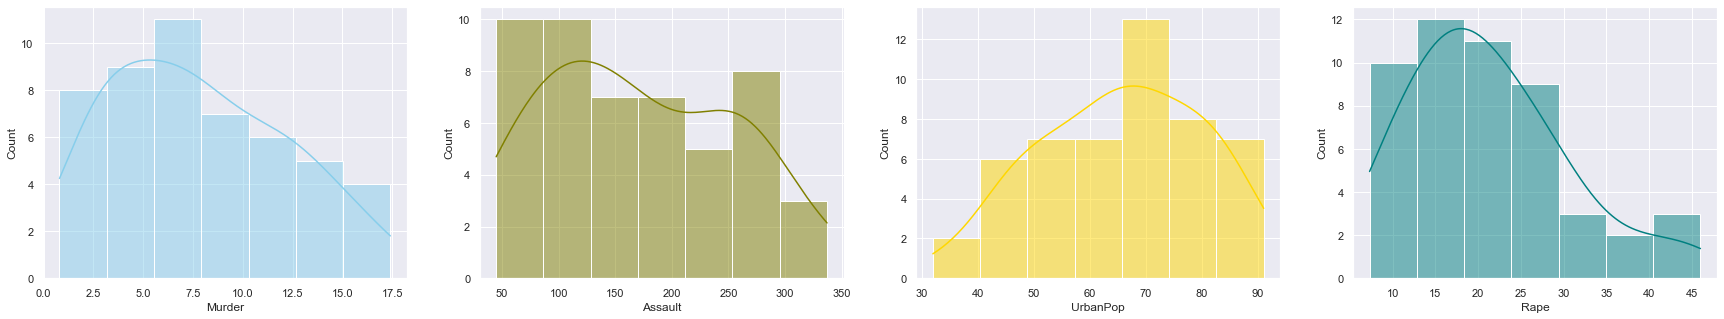

In [206]:
# Display each column as a histogram to get an overview of their distributions
sns. set(style = 'darkgrid')

fig, axs = plt.subplots(1, 4, figsize = (30,5))

sns.histplot(data = df, x = "Murder", kde = True, color = "skyblue", ax = axs[0])
sns.histplot(data = df, x = "Assault", kde = True, color = "olive", ax = axs[1])
sns.histplot(data = df, x = "UrbanPop", kde = True, color = "gold", ax = axs[2])
sns.histplot(data = df, x = "Rape", kde = True, color = "teal", ax = axs[3]);

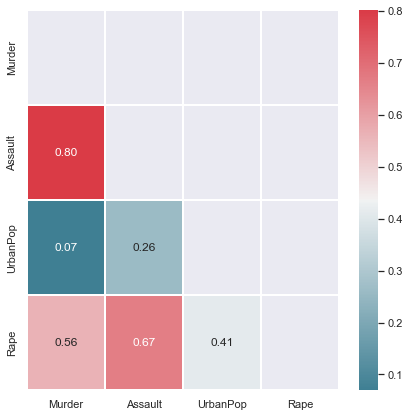

In [218]:
# Generate a correlation analysis of the data
colormap = sns.diverging_palette(220, 10, as_cmap=True)

# Get correlations for UsArrests features
corr = df.iloc[:,:].corr()

fig, ax = plt.subplots(figsize=(7, 7))

# Create an array of zeros the same shape as corr
drop_repeat = np.zeros_like(corr)

# Return the indices for the upper-triangle of the drop_repeat array
drop_repeat[np.triu_indices_from(drop_repeat)] = True

# Generate a heatmap with the repeating values masked by drop_repeat
ax = sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f", mask=drop_repeat, linewidth=2)

plt.show()

* From the correlation matrix, it is clear that Assault and Murder share a high correlation of 0.8.
* Rape shares relatively high positive correlations with Assault and Murder.
* It appears that UrbanPopulation and Murder aren't really correlated at all.
* UrbanPopulation shares a correlation of 0.41 with Rape.

In [208]:
# Generate a PCA model with 2 components
X = df.iloc[:, :]

# Apply PCA to data
pca = PCA(n_components=2)
princ_comp = pca.fit_transform(X)

# Create a dataframe from the PCA scaled data
pca_df = pd.DataFrame(princ_comp, columns = ['PC1', 'PC2'])
pca_df.head()

,PC1,PC2
0,64.802164,11.448007
1,92.827450,17.982943
2,124.068216,-8.830403
3,18.340035,16.703911
4,107.422953,-22.520070


In [209]:
# Function to generate a biplot from the data
def biplot(score,coef,labels=None):
 
    xs = score[:,0]
    ys = score[:,1]
    n = coef.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley,
                s=15, 
                color='blue')

    for i in range(n):
        plt.arrow(0, 0, coef[i,0], 
                  coef[i,1],color = 'red',
                  alpha = 0.5)
        plt.text(coef[i,0]* 1.15, 
                 coef[i,1] * 1.15, 
                 labels[i], 
                 color = 'green', 
                 ha = 'center', 
                 va = 'center')
 
    plt.xlabel("PC{}".format(1))
    plt.ylabel("PC{}".format(2))    
 
    plt.figure()

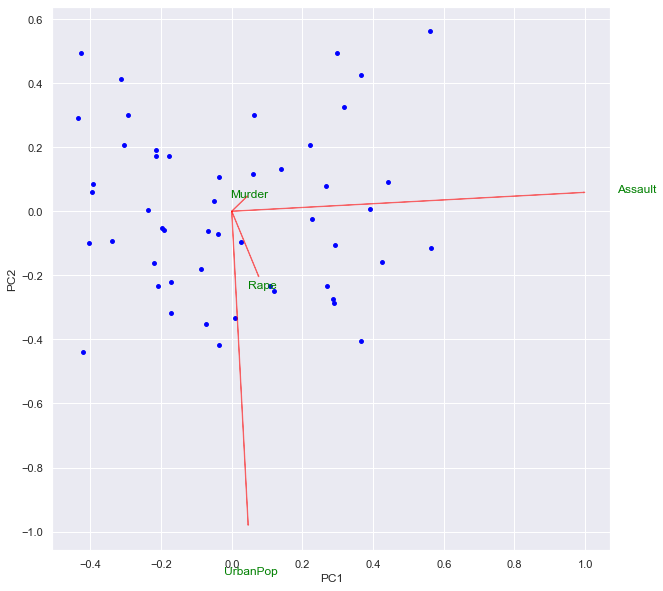

<Figure size 432x288 with 0 Axes>

In [210]:
# Generate biplot for the data
plt.figure(figsize = (10,10))
biplot(princ_comp, np.transpose(pca.components_), list(df.columns))

* It can be seen that UrbanPop and Assault are of higher influence than Murder and Rape, the data should be scaled so these features don't dominate.

In [211]:
# Define the independent variables and scale them 
scaled = MinMaxScaler().fit_transform(X)

# Apply PCA to the scaled data
pca_scaled = PCA(n_components=2)
princ_comp_scaled = pca_scaled.fit_transform(scaled)

# Create a dataframe from the PCA scaled data
pca_df_scaled = pd.DataFrame(princ_comp_scaled, index=df.index)
pca_df_scaled.head()

,0,1
0,0.293082,0.273177
1,0.497299,0.225498
2,0.460302,-0.201380
3,-0.006003,0.275698
4,0.612016,-0.409985


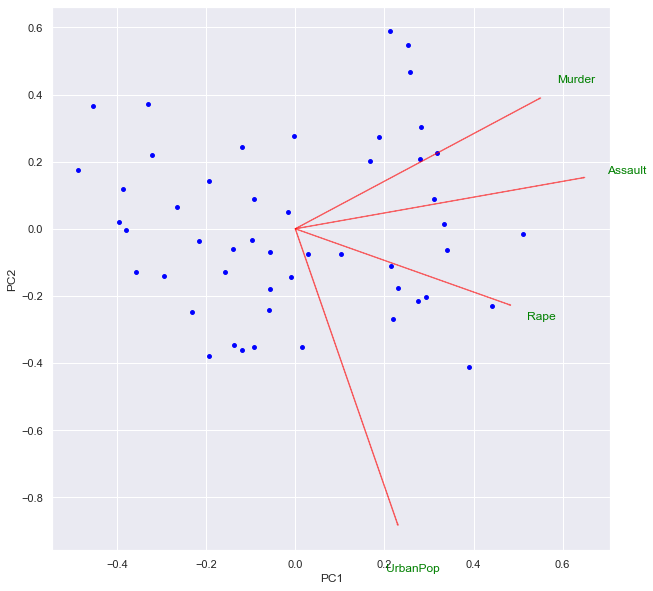

<Figure size 432x288 with 0 Axes>

In [212]:
plt.figure(figsize = (10,10))
biplot(princ_comp_scaled, np.transpose(pca_scaled.components_), list(df.columns))

* All variables appear to have positve loading along PC1.
* UrbanPop has more weight on PC2, whilst Assault, Rape and Murder seem to have weight on PC1.
* Murder and Assault are more positively correlated than Murder and Rape - this can be seen by the angle between the two vectors.
* Murder and UrbanPopulation aren't likely to be correlated, which can be seen by the 90 degree angle between the two vectors.

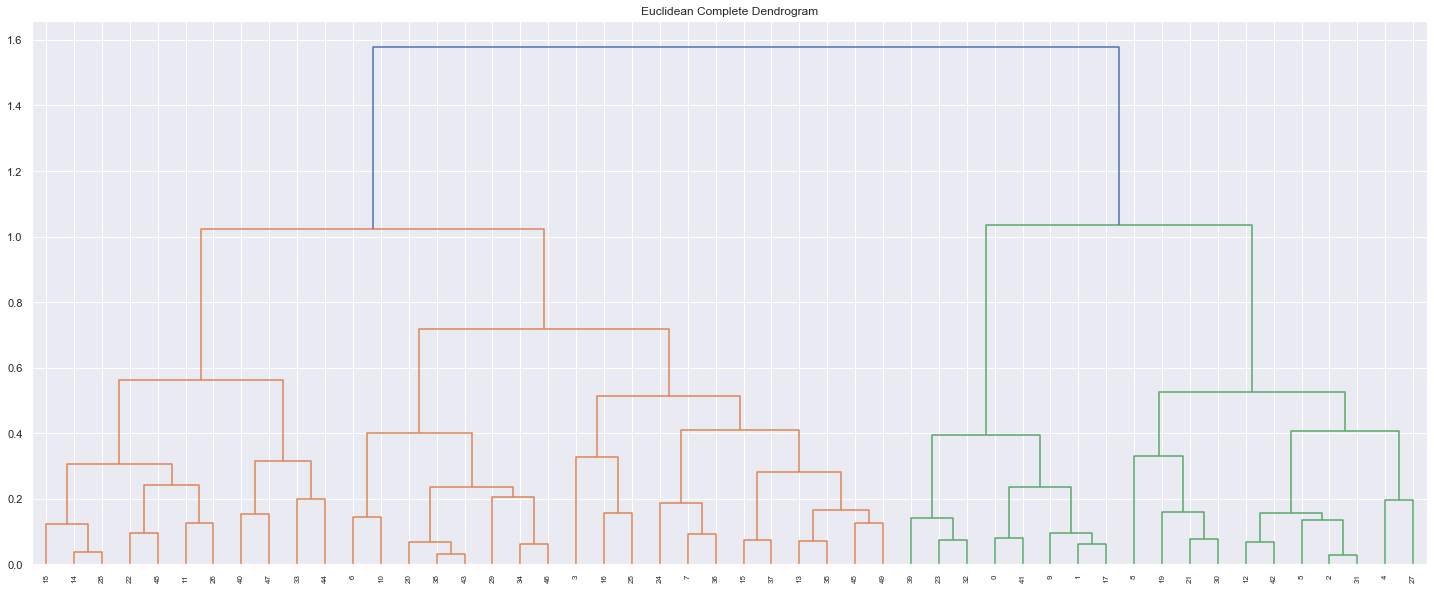

In [213]:
# Plot a dendrogram with complete linkage and euclidean distance metric
plt.figure(figsize = (25,10))
plt.title("Euclidean Complete Dendrogram")  
dend = dendrogram(linkage(princ_comp_scaled, method='complete', metric = 'euclidean'))  

* Using Euclidean distancing and complete linkage, we can see that the data forms 2 clusters around 1.0.

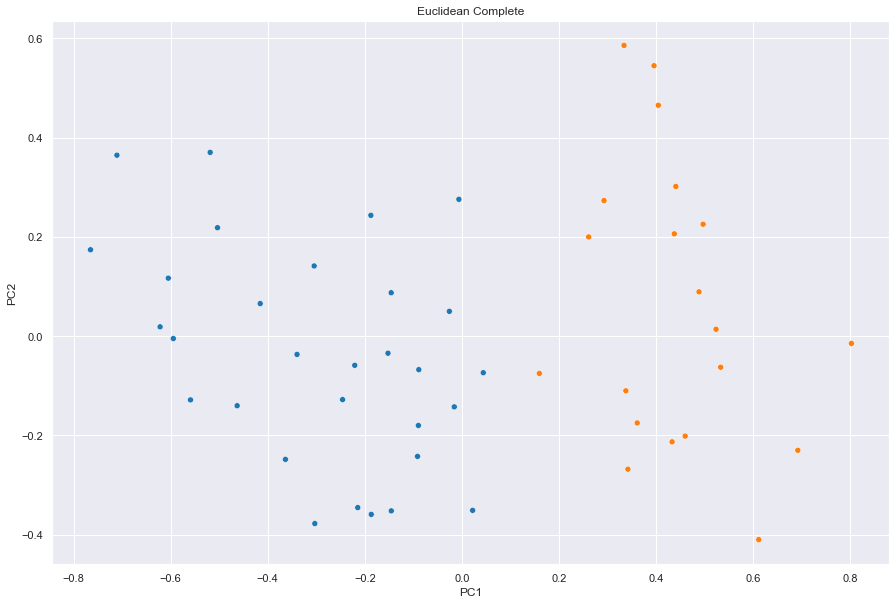

In [214]:
# Euclidean complete
plt.figure(figsize=(15,10))
# Generate clustering model
cluster = AgglomerativeClustering(n_clusters=2, affinity = 'euclidean', linkage = 'complete')
cluster.fit_predict(scaled)
# Plot clusters on a scatterplot
sns.scatterplot(data = princ_comp_scaled, x = princ_comp_scaled[:,0], y = princ_comp_scaled[:,1], hue = cluster.labels_, palette = 'tab10', legend = False).set(title = 'Euclidean Complete', xlabel = 'PC1', ylabel = 'PC2');

* Euclidean complete has separated the data into two clusters.
* The clusters appear to be split along PC1 rather than PC2.

In [215]:
# Generate a silhouette score on the clustering model
silhouette_score(princ_comp_scaled[:,[0,1]], metric = 'euclidean', labels = cluster.labels_)

0.49146750492287483

* The silhouette score of 0.49 shows that the data is somewhat informative, however, the data may not be definitive to a particular cluster due to the space between each data point.

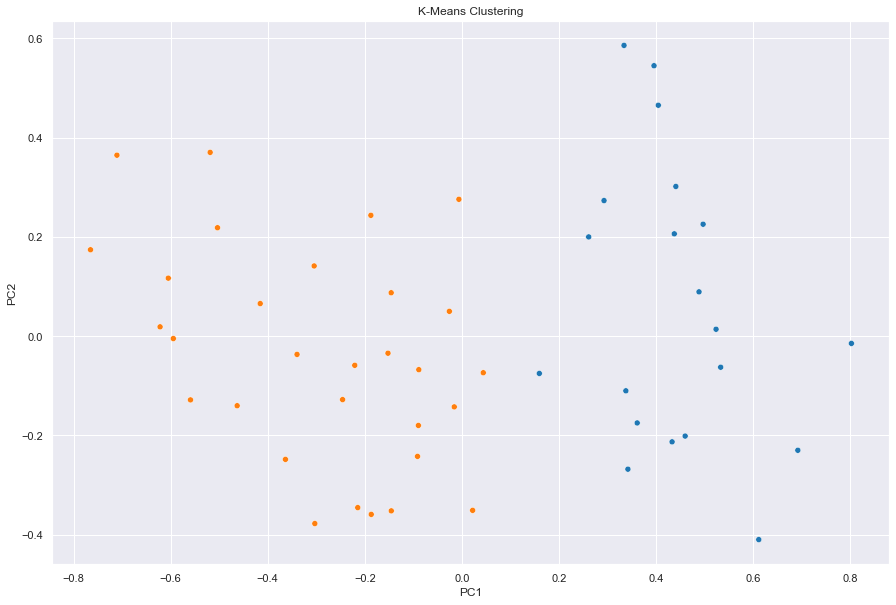

In [216]:
k_model = KMeans(n_clusters=2)
k_model.fit(pca_df_scaled)

plt.figure(figsize=(15,10))
sns.scatterplot(data = princ_comp_scaled, x = princ_comp_scaled[:,0], y = princ_comp_scaled[:,1], hue = k_model.labels_, palette = 'tab10', legend = False).set(title = 'K-Means Clustering', xlabel = 'PC1', ylabel = 'PC2');

In [217]:
# Generate a silhouette score on the K-means model
silhouette_score(princ_comp_scaled[:,[0,1]], labels = k_model.labels_)

0.49146750492287483

* From both scatterplot and silhouette score, it appears that k-means and agglomerative clustering approaches have assigned the same data points to the same clusters.
* Similarly to the hierarchical clustering approach, the data has been split into 2 clusters, however, these clusters may not be definitive. Data points are close together and some could easily be grouped into different clusters.